In [1]:
import glob
import pandas as pd

%matplotlib inline

In [2]:
def fill_pushers(df, DATA, num_samples, sample_interval):
    pushers = glob.glob('%s/push_*.txt'%DATA)

    #row=1
    
    for fname in pushers:
        row=1

        push_ind = int(fname.split('/')[2].strip().split('_')[1])
        #print push_ind
        f = open(fname,'r')
        times = f.readlines()
        f.close()
        
        

        start_time = float(times[0].split(' ')[0].strip())
        #print times[0]
        cnt=1
    
        for val in times[1:]:

            cur_time = float(val.split(' ')[0].strip())
            cnt+=1

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print '%s: Throughput: %s'%(nme, float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Push_proc_%s'%push_ind] = float(cnt/(cur_time-start_time))
                row+=1
            
    return df

In [3]:
def fill_poppers(df, DATA, num_samples, sample_interval):
    poppers = glob.glob('%s/pop_*.txt'%DATA)

    for fname in poppers:
        row=1

        pop_ind = int(fname.split('/')[2].strip().split('_')[1])
        #print pop_ind
        f = open(fname,'r')
        times = f.readlines()

        start_time = float(times[0].split(' ')[0].strip())
        #print times[0]
        cnt=1
    
        for val in times[1:]:

            cur_time = float(val.split(' ')[0].strip())
            cnt+=1

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print '%s: Throughput: %s'%(nme, float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Pop_proc_%s'%pop_ind] = float(cnt/(cur_time-start_time))
                row+=1
            
    #print df
    return df

In [4]:
def get_throughput_plot(num_push_procs, num_pop_procs, num_queues, num_samples):

    push_cols_avg = ['Push_proc_%s'%i for i in range(num_push_procs)]
    #push_cols_err = ['Push_proc_%s'%i for i in range(num_push_procs)]
    pop_cols_avg = ['Pop_proc_%s'%i for i in range(num_pop_procs)]
    #pop_cols_err = ['Pop_proc_%s'%i for i in range(num_pop_procs)]
    cols = push_cols_avg + pop_cols_avg# push_cols_err + pop_cols_err

    DATA = './push_%s_pop_%s_q_%s_trial_0'%(num_push_procs, num_pop_procs, num_queues)
    
    indices = []
    sample_interval = 1000000/num_samples
    
    for i in range(num_samples+1):
        indices.append(i*sample_interval)

    df = pd.DataFrame(columns=cols, index=indices)
    
    df = fill_pushers(df, DATA, num_samples, sample_interval)
    df = fill_poppers(df, DATA, num_samples, sample_interval)
    
    #print df
    maxx = 1.25* df.max().max()
    ax = df.plot(kind='line', y=cols, use_index=True, ylim=(0,maxx), 
             title='Throughput with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                                    num_pop_procs,
                                                                                    num_queues)
            )
    ax.set_ylabel('Task per second')
    ax.set_xlabel('Total number of tasks')
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1, 0.5))

In [5]:
def fill_push_queue(df, DATA, num_samples, sample_interval):
    
    queues = glob.glob('%s/push_*.txt'%DATA)

    #row=1
    
    for fname in queues:
        row=1

        proc_ind = push_ind = int(fname.split('/')[2].strip().split('_')[1])
        #print q_ind
        f = open(fname,'r')
        lines = f.readlines()
        f.close()
        
        cnt=1
    
        for val in lines:

            q_len = float(val.split(' ')[1].strip())
            q_size = float(val.split(' ')[2].strip())

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print '%s: Throughput: %s'%(nme, float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Queue-len-push-proc-%s'%proc_ind] = q_len
                df.loc[row*sample_interval]['Queue-size-push-proc-%s'%proc_ind] = q_size
                row+=1
                
            cnt+=1
            
    return df

In [6]:
def get_queue_push_plot(num_push_procs, num_pop_procs, num_queues, num_samples):
    
    indices = []
    
    sample_interval = 1000000/num_samples
    
    for i in range(num_samples+1):
        indices.append(i*sample_interval)
    
    queue_len = ['Queue-len-push-proc-%s'%i for i in range(num_push_procs)]
    queue_size = ['Queue-size-push-proc-%s'%i for i in range(num_push_procs)]
    
    cols = queue_len + queue_size
    df = pd.DataFrame(columns=cols, index=indices)
    
    DATA = './push_%s_pop_%s_q_%s_trial_0'%(num_push_procs, num_pop_procs, num_queues)
    df = fill_push_queue(df, DATA, num_samples, sample_interval)
    
    #maxx = 1.25*df.max().max()
    
    ax = df.plot(kind='line', y=queue_len, use_index=True, 
             title='Queue length as seen by each push \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
             
    ax.set_ylabel('Queue length')
    ax.set_xlabel('Total number of tasks')
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1.2, 0.5))
    
    '''
    ax1 = df.plot(kind='line', y=queue_size, use_index=True,
                  title='Queue size(bytes) as seen by each push \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
    
    ax1.set_ylabel('Queue size (bytes)')
    ax1.set_xlabel('Total number of tasks')
    patches, labels = ax1.get_legend_handles_labels()
    ax1.legend(patches, labels, loc='lower left',bbox_to_anchor=(1.2, 0.5))
    '''

In [7]:
def fill_pop_queue(df, DATA, num_samples, sample_interval):
    
    queues = glob.glob('%s/pop_*.txt'%DATA)

    #row=1
    
    for fname in queues:
        row=1

        proc_ind = push_ind = int(fname.split('/')[2].strip().split('_')[1])
        #print q_ind
        f = open(fname,'r')
        lines = f.readlines()
        f.close()
        
        cnt=1
    
        for val in lines:

            q_len = float(val.split(' ')[1].strip())
            q_size = float(val.split(' ')[2].strip())

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print '%s: Throughput: %s'%(nme, float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Queue-len-pop-proc-%s'%proc_ind] = q_len
                df.loc[row*sample_interval]['Queue-size-pop-proc-%s'%proc_ind] = q_size
                row+=1
                
            cnt+=1
            
    return df

In [8]:
def get_queue_pop_plot(num_push_procs, num_pop_procs, num_queues, num_samples):
    
    indices = []

    sample_interval = 1000000/num_samples
    
    for i in range(num_samples+1):
        indices.append(i*sample_interval)
    
    queue_len = ['Queue-len-pop-proc-%s'%i for i in range(num_pop_procs)]
    queue_size = ['Queue-size-pop-proc-%s'%i for i in range(num_pop_procs)]
    
    cols = queue_len + queue_size
    df = pd.DataFrame(columns=cols, index=indices)
    
    DATA = './push_%s_pop_%s_q_%s_trial_0'%(num_push_procs, num_pop_procs, num_queues)
    df = fill_pop_queue(df, DATA, num_samples, sample_interval)
    
    #maxx = 1.25*df.max().max()
    
    ax = df.plot(kind='line', y=queue_len, use_index=True, 
             title='Queue length as seen by each pop \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
             
    ax.set_ylabel('Queue length')
    ax.set_xlabel('Total number of tasks')
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1.2, 0.5))
    
    '''
    ax1 = df.plot(kind='line', y=queue_size, use_index=True,
                  title='Queue size(bytes) as seen by each push \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
    
    
    ax1.set_ylabel('Queue size (bytes)')
    ax1.set_xlabel('Total number of tasks')
    patches, labels = ax1.get_legend_handles_labels()
    ax1.legend(patches, labels, loc='lower left',bbox_to_anchor=(1.2, 0.5))
    '''

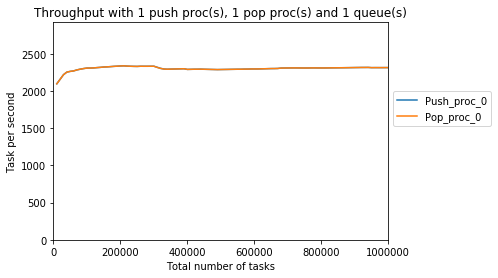

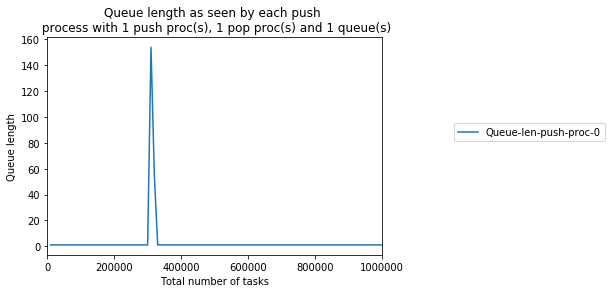

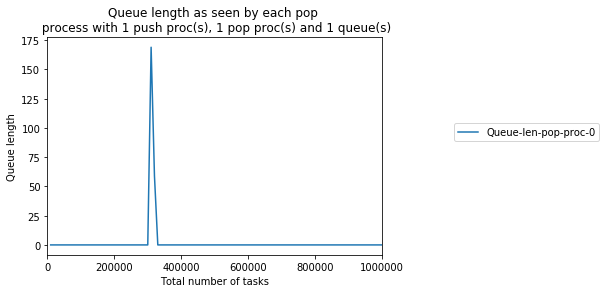

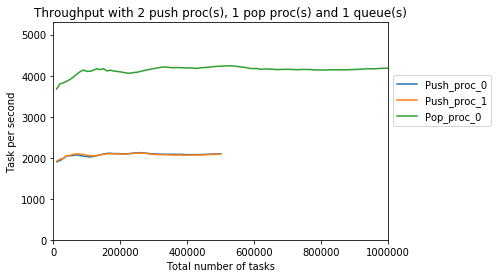

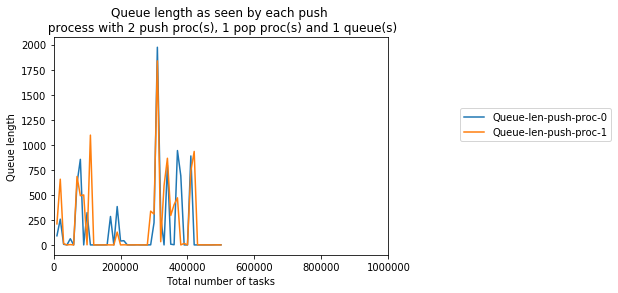

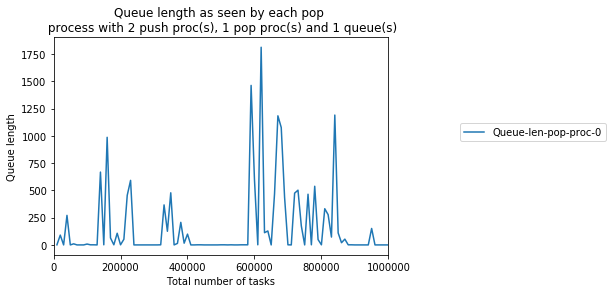

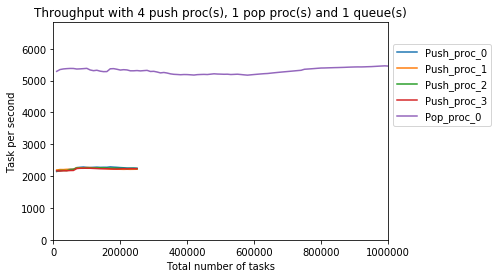

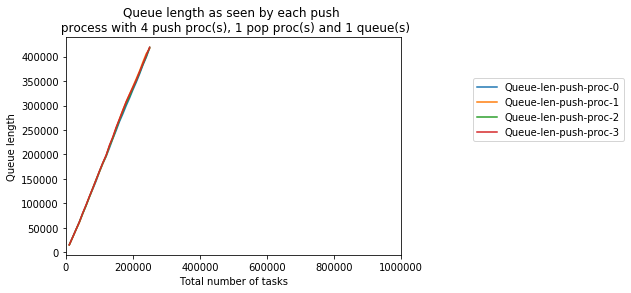

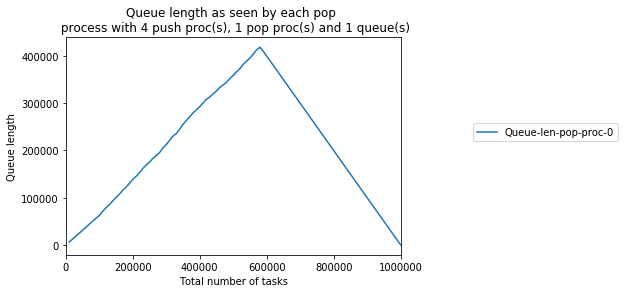

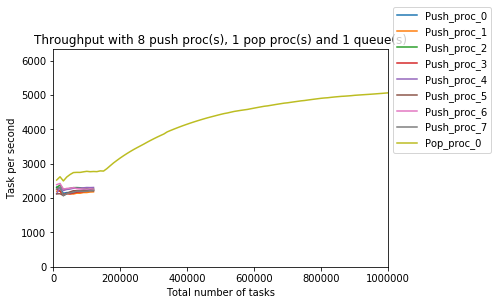

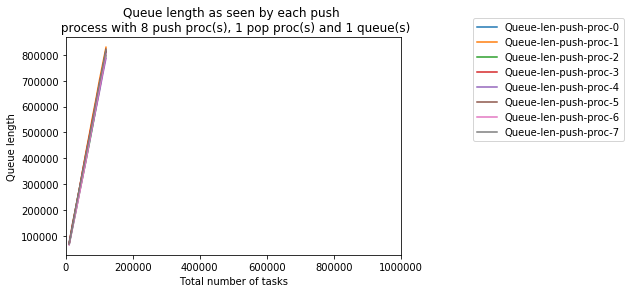

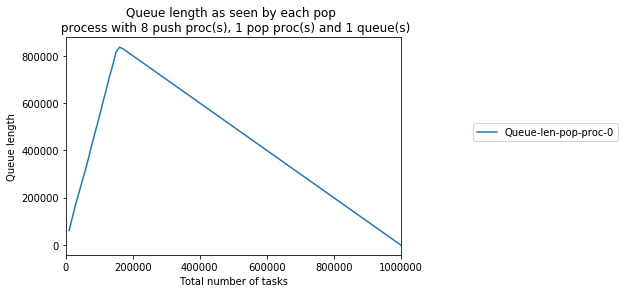

In [9]:
num_push_procs_list = [1,2,4,8]
num_pop_procs = 1
num_queues = 1
num_samples = 100

for num_push_procs in num_push_procs_list:
    get_throughput_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_push_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_pop_plot(num_push_procs, num_pop_procs, num_queues, num_samples)

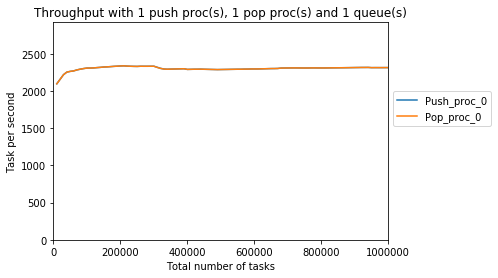

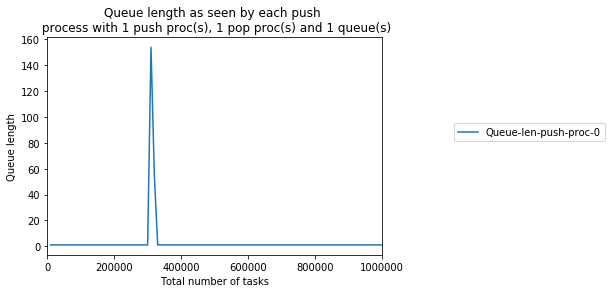

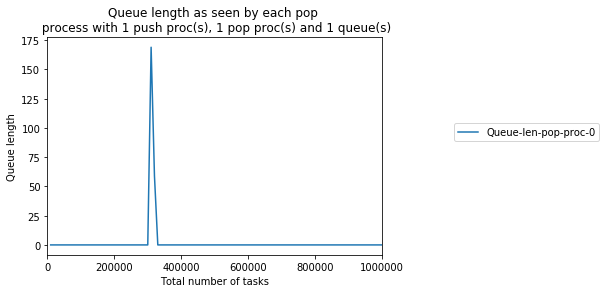

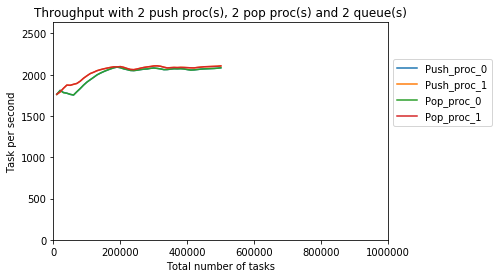

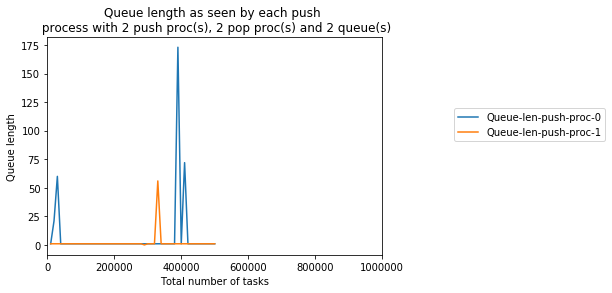

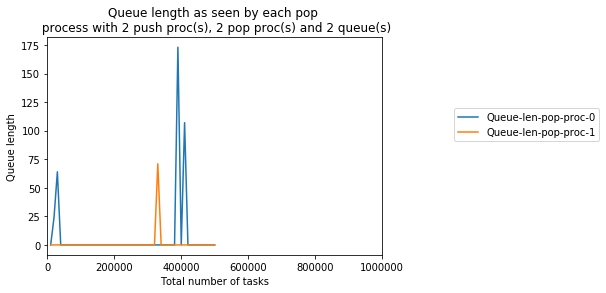

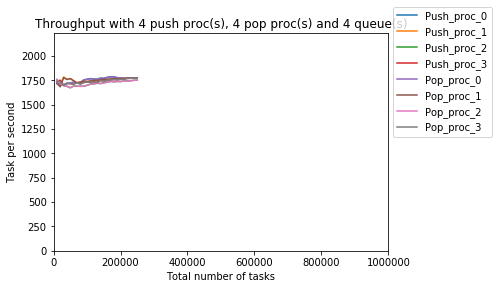

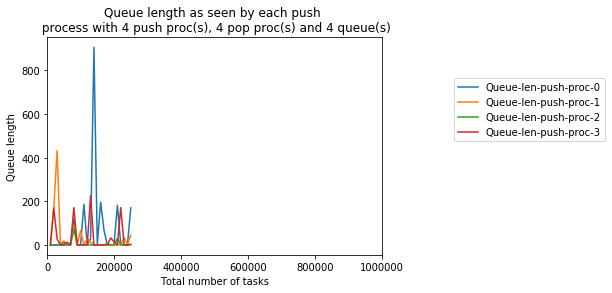

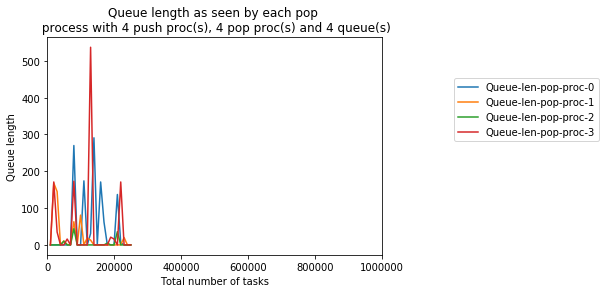

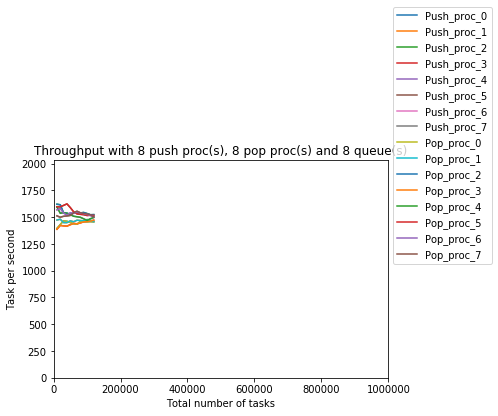

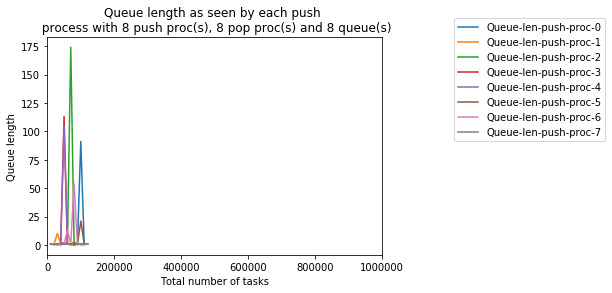

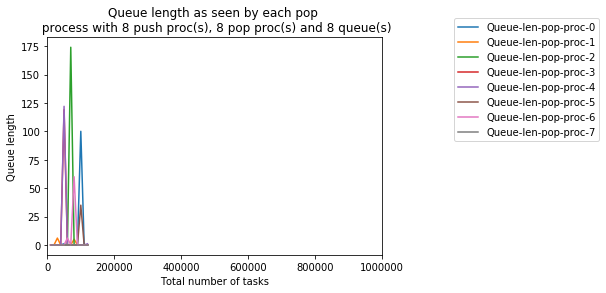

In [10]:
num_queues_list = [1,2,4, 8]
num_samples = 100

for num_queues in num_queues_list:
    num_push_procs= num_queues
    num_pop_procs= num_queues
    get_throughput_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_push_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_pop_plot(num_push_procs, num_pop_procs, num_queues, num_samples)